# Testing LDA Modeling

This notebook will be the playground and demonstration for the LDA modeling of our data.

---


## Step 1: Get the Data

First we start by importing the necessary libraries and data. We import `nltk` and download the library files. These files need to be freshly downloaded and available locally. It is safe to download them again, they will update or ignore depending on if they are already present and/or have updates.

I use pprint just for testing in this jupyter notebook, but they aren't necessary in real code. [Pandas](https://pandas.pydata.org/) of course is needed for most of the data manipulation and analysis.

Next, we  can import the collected data into a `pandas` dataframe.

In [2]:
# This is needed to download the NLTK data for later use.
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacurtis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacurtis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pprint

import pandas as pd

posts = pd.read_csv('../datasources/most_recent_all.csv', index_col='id')
posts.head()

,title,url,tag_array,content,content_clean,content_html,votes,answers,views,accepted,detailed,definitive,created_at,updated_at
id,,,,,,,,,,,,,,
76973749,PrimeVue DataTable Component #Filter slot not ...,https://stackoverflow.com/questions/76973749/p...,"['laravel', 'vue.js', 'primevue']",I'm using PrimeVue within a Vue app and I'm sp...,I'm using PrimeVue within a Vue app and I'm sp...,"<div class=""s-prose js-post-body"" itemprop=""te...",0,0,9,0,1,0,2023-08-25 01:30:52,2023-08-25 01:30:52
76949187,Persisting Client IP address in rest apis depl...,https://stackoverflow.com/questions/76949187/p...,"['kubernetes', 'networking', 'azure-aks']",Persisting Client IP address in rest apis depl...,Persisting Client IP address in rest apis depl...,"<div class=""s-prose js-post-body"" itemprop=""te...",0,1,16,0,1,0,2023-08-21 23:08:40,2023-08-22 20:55:58
76949101,JSON related error (maybe) on kubectl patch se...,https://stackoverflow.com/questions/76949101/j...,"['kubernetes', 'kubectl']",I'm following this digital ocean tutorial and ...,I'm following this digital ocean tutorial and ...,"<div class=""s-prose js-post-body"" itemprop=""te...",0,0,27,0,1,0,2023-08-21 22:41:15,2023-08-21 22:41:15
76948566,istio API aggregation gateway,https://stackoverflow.com/questions/76948566/i...,"['kubernetes', 'istio', 'istio-gateway', 'isti...",I have kubernetes and use istio. Can you tell ...,I have kubernetes and use istio. Can you tell ...,"<div class=""s-prose js-post-body"" itemprop=""te...",-2,0,22,0,1,0,2023-08-21 20:34:51,2023-08-21 20:34:51
76948542,Kubernetes - how to wait for initContainers to...,https://stackoverflow.com/questions/76948542/k...,['kubernetes'],I have several deployment manifest files corre...,I have several deployment manifest files corre...,"<div class=""s-prose js-post-body"" itemprop=""te...",1,0,25,0,1,0,2023-08-21 20:29:28,2023-08-21 20:29:28


If we plot these results, we see that most of the recent posts actually have zero votes. _Interesting!_

<Axes: xlabel='votes', ylabel='count'>

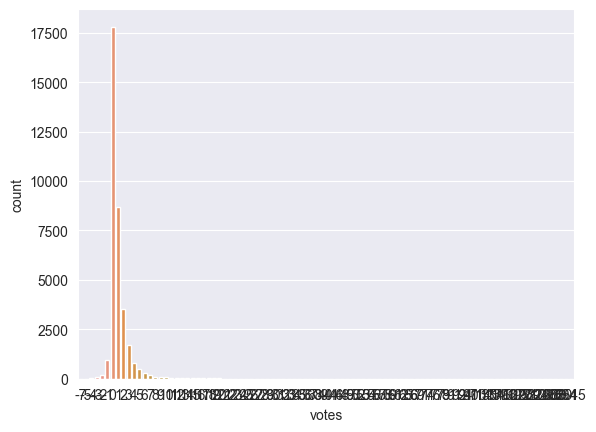

In [5]:
plot_data = posts[['title', 'votes']]
import seaborn as sns
sns.countplot(data=plot_data, x="votes")

That is the data, we now have it in a Pandas dataframe. This makes it easier to manipulate.

## Step 2: Data Cleaning and Preprocessing

Before starting topic modeling, we need to prepare the text and perform cleaning and preprocessing. This is a crucial step in all text mining pipelines and the end model’s future performance and accuracy, will highly depends on how thoroughly and pragmatically we perform this step.

The steps we will follow for this dataset are:

1. Remove NaN values
2. Add the title to the content (we want it to be considered in topic modeling)
3. Lowercase the content text
4. Replace contractions with longer forms 
5. Remove punctuation
6. Remove stopwords (unwanted words) 

### Step 2-1: Remove NaN Values

First we check for NaN values, and remove them if they exist. NaN values can cause issues with the model, so we want to remove them before we start.

We can see that there are some NaN values in the `title` column and in the `content_clean` column. We will remove these values. Otherwise when we try to mass concatenate the title and content, we will get NaN values in the resulting column which causes the model to fail.

In [6]:
# Check for NaN Values, and remove them if they exist
posts[['title', 'content_clean']].isna().sum()

title            0
content_clean    9
dtype: int64

In [7]:
# Now NaN values are removed and Printed Again to Demonstrate that they are gone
posts.loc[:, ['title', 'content_clean']] = posts[['title', 'content_clean']].fillna("")
posts[['title', 'content_clean']].isna().sum()

title            0
content_clean    0
dtype: int64

### Step 2-2: Add the Title to the Content

Now we know there are no `NaN` values, so we can safely create the `title_post` column, which concatenates these two columns (starting with title of course).
 
This combination column is important because we want to consider the title of the post in the topic modeling. The title is often a good indicator of the topic of the post, and we want to make sure it is considered in the model learning. Ultimately, the computer just sees them all as tokenized words anyway, so as strange as it seems to be combining these, it will be beneficial in the end.

In [8]:
# Earlier implementation of this was:
# posts['title_post'] = posts['title'].str.cat(posts['content_clean'], sep=" ")
# The zipped list comprehension is much faster (by 2-3x in my tests).

posts['title_post'] = [' '.join(i) for i in zip(posts['title'], posts['content_clean'])]
posts['title_post'].sample(10) # Show random sample of 10 just to confirm it works 

# NOTE: the results above are truncated by jupyter notebook, run the below command to see the full text
# posts.loc[76645048 , 'title_post'] # Replace 76645048 with any id from the sample above

id
63998292    Kubernetes client python API error 401 - Unaut...
71169528    kubernetes init container for spark-submit I a...
60012534    How to assign IP address to an Ingress Control...
62941711    Choose the correct version of etcd backup in K...
75996490    How do I solve acme: authorization 403 error w...
65704823    Keycloak realm probe is not getting ready I am...
76300871    ERROR: Unable to create pod kubernetes jenkins...
67477799    kubectl works on server but not in container I...
71837512    Ingress not forwarding traffic to pod Ingress ...
73700278    when i restart a pod , it shows "Volume is alr...
Name: title_post, dtype: object

### Step 2-3: Lowercase the Content Text

The next 3 steps will be done in a single function and will be collectively referred to as "pre-processing". 

The first of these steps is to lowercase the content text. We want to lowercase everything in the content because otherwise, the model will treat the same word as different words because it will see Hello, hello, and HELLO as different words. We want to treat them all as the same word, so we lowercase everything.

### Step 2-4: Replace Contractions

Next, we want to remove contractions. This will remove words like "can't" and replace them with "can not". This is important because we want to treat these as separate words. If we don't do this, the model will treat "can't" and "can not" as different words, and we want to treat them as the same word. It also simplifies the removal of stop words (which will be later).

This is completed with the help of the `contractions` library. This library is not part of the standard python library, so it will need to be installed with `pip install contractions`.

### Step 2-5: Remove Punctuation

Finally, we can remove punctuation. Our model is concerned with meaning, and punctuation doesn't add meaning, it just adds structure. So we can remove it without losing any meaning. This is done with the help of Regex and the `re` library, which is part of the standard python library.

In addition, as part of this step we also remove urls from the text if there are any. Again, this is accomplished with regex and the same `re` library.

### Step 2-6: Lemmatize Words

The final step in pre-processing is to lemmatize all the words. Lemmatization is the process of distilling words into their root form (also known as _"lemma"_). For example, "running" and "ran" would both be distilled into "run". This is important because we want to treat these words as the same word since they have the same meaning. 

If we don't do this, the model will treat the same ideas or various tenses as different words, and we want to treat them as the same word. 

This is accomplished thanks to the `nltk` library, which is thoroughly covered and updated by the open source community.

### Step 2-7: Remove Stopwords

We see in the above wordcloud and box plot that there are some words that are very common, but don't add much meaning. These words are called "stopwords" and we want to remove them.

Notably, these words include but are not limited to:

* the
* to
* be
* and
* in
* have
* it
* this


---

All of these steps (2-3 through 2-6) are accomplished in the `text_preprocessing` function below. This function takes in a string, and returns a list of tokenized words.

In [9]:
import contractions
import re

def text_preprocessing(text_to_preprocess):
    text = str(text_to_preprocess)
    
    # Convert words to lower case
    text = text.lower()

    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            contractions.fix(word)
            new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)

    
    # Remove stopwords
    # filtered_text = []
    stop_words = stopwords.words('english')
    stop_words.extend(['k8s', 'kubernetes', 'use'])
    stop_words = set(stop_words)
    # for w in text:
    #     if w not in stop_words:
    #         filtered_text.append(w)
    filtered_text = " ".join([word for word in text.split() if word not in stop_words])

    # Tokenize each word
    tokenized = nltk.WordPunctTokenizer().tokenize(filtered_text)
    
    # Lemmatize each word, drop single letter words
    tokenized = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in tokenized if len(token)>1]
    return tokenized

def tokenized_to_text(tokenized):
    return ' '.join(map(str, tokenized))

# STOP_WORDS = stopwords.words('english')
# STOP_WORDS.extend(['k8s', 'kubernetes', 'kubernets', 'use'])
# STOP_WORDS = set(STOP_WORDS)
# 
# print(STOP_WORDS)

We call the function in the next few lines were we create columns for both `tokenized_content` and `processed_content`.

In [10]:
# Visually confirm that the title and content are combined
posts['tokenized_content'] = posts['title_post'].apply(text_preprocessing)
posts['processed_content'] = posts['tokenized_content'].apply(tokenized_to_text)
posts.sample(10)


NameError: name 'stopwords' is not defined

In [357]:
from collections import Counter
from itertools import chain

all_content = posts['tokenized_content'].values.tolist()
Counter = Counter(chain(*all_content))
most_frequent = Counter.most_common(30)
pprint.pprint(most_frequent)


[('pod', 43096),
 ('use', 27620),
 ('cluster', 26875),
 ('run', 26260),
 ('service', 24539),
 ('get', 21599),
 ('try', 20419),
 ('create', 18198),
 ('file', 17081),
 ('error', 15514),
 ('work', 15393),
 ('ingress', 13641),
 ('deployment', 12675),
 ('deploy', 12338),
 ('yaml', 12268),
 ('node', 11905),
 ('container', 11465),
 ('like', 11395),
 ('docker', 10931),
 ('follow', 10469),
 ('want', 9950),
 ('log', 9778),
 ('kubectl', 9555),
 ('one', 9475),
 ('application', 9376),
 ('image', 9220),
 ('command', 9115),
 ('set', 8502),
 ('need', 8379),
 ('server', 8104)]


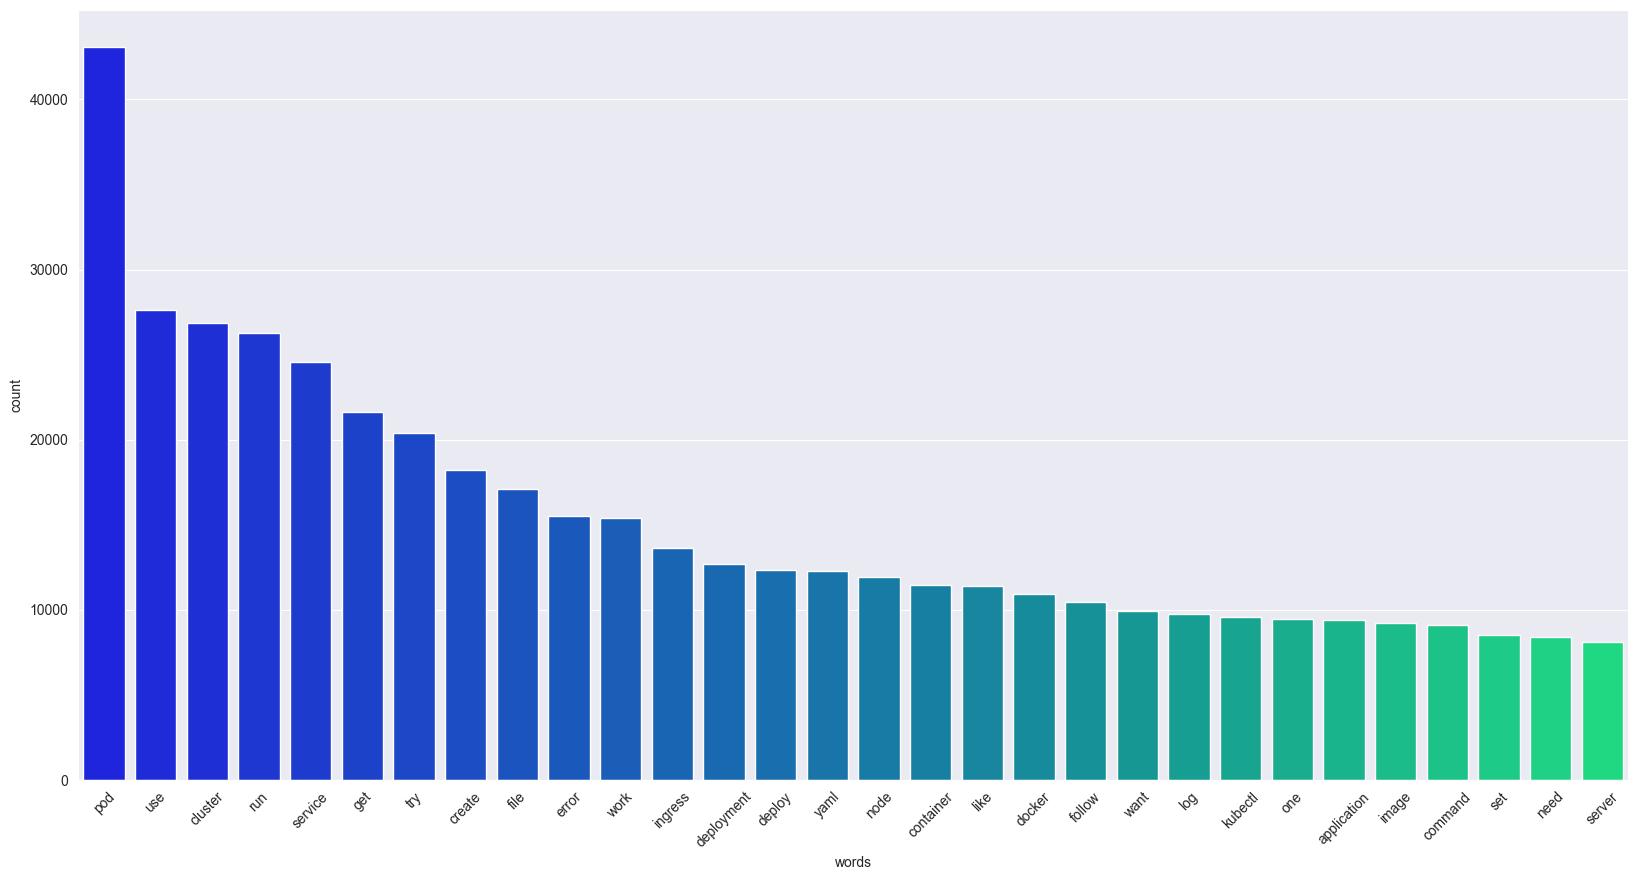

In [358]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

/Users/jacurtis/Developer/k8s-scrape/.venv/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


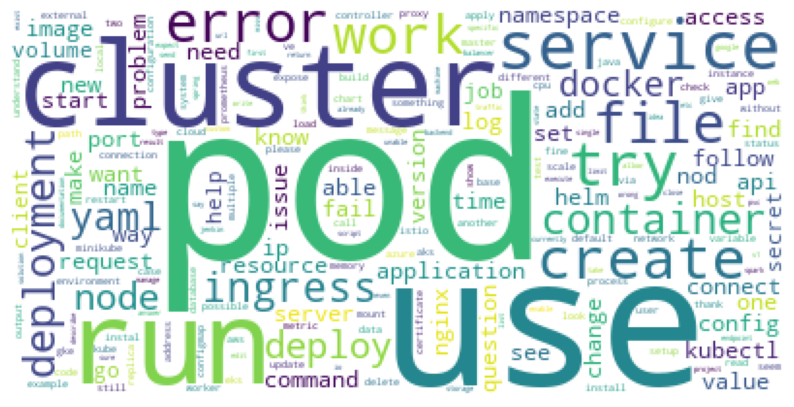

In [359]:
from wordcloud import WordCloud
wc_words = ','.join(chain(*all_content))

wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(wc_words)
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## Time to Build the Model

Now that we have the data cleaned and pre-processed, we can start building the model. We will use the `gensim` library to build the model. This library is not part of the standard python library, so it will need to be installed with `pip install gensim`.

In [360]:
import gensim
# Create Dictionary
id2word = gensim.corpora.Dictionary(posts['tokenized_content'])

In [361]:
print(id2word)

Dictionary<37978 unique tokens: ['10', 'anyone', 'app', 'appear', 'body']...>


In [362]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in posts['tokenized_content']]

print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 37978
Number of documents: 35417


### Training the model

The first thing we want to do is enable logging. Because we will need to play with the model variables frequently and tweak them until we build a good model. With the logging, we should be able to determine which variables are the most important and which ones we should tweak.

In [381]:
import logging
logging.basicConfig(filename="lda_build.log",
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.DEBUG)


In [380]:
for handler in logging.root.handlers[:]:
   logging.root.removeHandler(handler)

In [407]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            chunksize=2000,
                                            iterations=100,
                                            passes=20,
                                            alpha='auto',
                                            update_every=1,
                                            random_state=100,
                                            num_topics=25)

In [393]:
lda_model.top_topics(corpus)

[([(0.055644095, 'get'),
   (0.05276211, 'try'),
   (0.039238676, 'error'),
   (0.039191935, 'use'),
   (0.031068115, 'file'),
   (0.030326359, 'kubectl'),
   (0.029802622, 'create'),
   (0.029394386, 'deployment'),
   (0.029213855, 'follow'),
   (0.02674431, 'command'),
   (0.02672259, 'work'),
   (0.02564079, 'run'),
   (0.025588335, 'yaml'),
   (0.020334657, 'deploy'),
   (0.015555213, 'config'),
   (0.011499977, 'see'),
   (0.01136558, 'issue'),
   (0.010349061, 'find'),
   (0.010177083, 'help'),
   (0.009976584, 'fail')],
  -1.5476650718310763),
 ([(0.031615477, 'cluster'),
   (0.028398225, 'like'),
   (0.022584904, 'want'),
   (0.02247827, 'use'),
   (0.021535182, 'need'),
   (0.019493727, 'way'),
   (0.01912647, 'one'),
   (0.018911801, 'would'),
   (0.012717266, 'set'),
   (0.012120133, 'know'),
   (0.011122143, 'make'),
   (0.010943934, 'different'),
   (0.01053854, 'possible'),
   (0.010043108, 'new'),
   (0.009328561, 'look'),
   (0.008861072, 'deploy'),
   (0.008681782, 'fi

In [1]:
import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis = pyLDAvis.gensim.prepared_data_to_html(lda_model, corpus, id2word)
# pyLDAvis.save_html(vis, 'lda.html')
vis

NameError: name 'lda_model' is not defined

In [406]:
lda_model.save('../datasources/lda_models/lda2/model.gensim')